In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import pandas as pd
import pylhe
from tqdm import tqdm
import itertools

In [57]:
import os 
root_dirs = '../root/MG5_aMC_v2_7_3/SS2l_test/Events/'

In [59]:
root_name = ['run_01/tag_1_delphes_events.root', 'run_02/tag_1_delphes_events.root',
             'run_03/tag_1_delphes_events.root', 'run_04/tag_1_delphes_events.root',
             'run_05/tag_1_delphes_events.root', 'run_06/tag_1_delphes_events.root',
             'run_07/tag_1_delphes_events.root', 'run_08/tag_1_delphes_events.root',
             'run_09/tag_1_delphes_events.root', 'run_10/tag_1_delphes_events.root',
             'run_11/tag_1_delphes_events.root', 'run_12/tag_1_delphes_events.root',
             'run_13/tag_1_delphes_events.root', 'run_14/tag_1_delphes_events.root',
             'run_15/tag_1_delphes_events.root', 'run_16/tag_1_delphes_events.root',
             'run_17/tag_1_delphes_events.root', 'run_18/tag_1_delphes_events.root',
             'run_19/tag_1_delphes_events.root', 'run_20/tag_1_delphes_events.root',
             'run_21/tag_1_delphes_events.root', 'run_22/tag_1_delphes_events.root',
             'run_23/tag_1_delphes_events.root', 'run_24/tag_1_delphes_events.root',]
f_tA = [uproot.open(root_dirs + name) for i, name in enumerate(root_name)]

In [ ]:
f_tA[0]['Delphes;1'].show()

In [56]:
def f(deltaeta, deltaphi):
    return np.sqrt(deltaeta**2 + deltaphi**2)
def function(f_Att):
    # Define Tree
    tree_electron_Att = f_Att['Delphes;1/Electron']
    tree_muon_Att = f_Att['Delphes;1/Muon']
    tree_jet_Att = f_Att['Delphes;1/Jet']
    tree_Emiss_Att = f_Att['Delphes;1/MissingET']
    
    # Define Branches
    Att_electron = tree_electron_Att.arrays(['Electron.Charge',
                                            'Electron.PT',
                                            'Electron.Eta',
                                            'Electron.Phi'], library='ak')
    Att_muon = tree_muon_Att.arrays(['Muon.Charge',
                                    'Muon.PT',
                                    'Muon.Eta',
                                    'Muon.Phi'], library='ak')
    Att_jet = tree_jet_Att.arrays(['Jet.Mass',
                                   'Jet.BTag',
                                   'Jet.PT',
                                   'Jet.Eta', 
                                   'Jet.Phi'], library='ak')
    Att_Emiss = tree_Emiss_Att.arrays(['MissingET.MET',
                                       'MissingET.Phi'], library='ak')
    
    # Define Variables
    EventSize = len(Att_jet['Jet.Mass'])
    jet_sort_pt = ak.sort(Att_jet['Jet.PT'], axis=-1, ascending=False)
    jet_num = ak.num(Att_jet['Jet.PT'], axis=-1)
    lepton_sort_pt = ak.sort(ak.concatenate([Att_electron['Electron.PT'], Att_muon['Muon.PT']], axis=-1), axis=-1, ascending=False)
    lepton_charge = ak.Array.tolist(ak.concatenate([Att_electron['Electron.Charge'], Att_muon['Muon.Charge']], axis=-1))
    lepton_eta = ak.concatenate([Att_electron['Electron.Eta'], Att_muon['Muon.Eta']], axis=-1)
    lepton_phi = ak.concatenate([Att_electron['Electron.Phi'], Att_muon['Muon.Phi']], axis=-1)
    bjet_pt = Att_jet['Jet.PT']*Att_jet['Jet.BTag']
    bjet_eta = Att_jet['Jet.Eta']*Att_jet['Jet.BTag']
    bjet_phi = Att_jet['Jet.Phi']*Att_jet['Jet.BTag']
    two_lepton = ak.where(ak.num(lepton_sort_pt)>=2)
    
    # Two leptons with same charge + at least 3 jets with 2 of them identified as b-jets
    event_signal = []
    for i in tqdm(two_lepton[0]): #Awkward Array has a length of 1
        num_jet, b_pt, lep_charge = jet_num[i], bjet_pt[i], lepton_charge[i]
        num_bjet = len(b_pt[ak.where(b_pt)])
        if lep_charge.count(-1) >= 2 or lep_charge.count(1) >=2:
            if num_jet >= 3 and num_bjet >=2:
                event_signal.append(i)
        
    # Transverse Momentum of leading and subleading lepton $ Eta for Leptons
    event_lep = []
    for i in tqdm(event_signal):
        lep_eta = lepton_eta[i]
        lep_where = ak.where(np.abs(lep_eta)<2.5, 0, lep_eta)
        if lepton_sort_pt[i][0] > 25 and lepton_sort_pt[i][1] > 20 and ak.count_nonzero(lep_where) == 0:
            event_lep.append(i)
        else:
            continue
    
    # Transverse Momentum of leading and subleading b-jet & Eta for b-jets
    event_jet = []
    for i in tqdm(event_lep):
        b_pt, b_eta  = bjet_pt[i], bjet_eta[i]
        b_pt = b_pt[ak.where(b_pt)]
        b_pt = ak.sort(b_pt, ascending=False)
        bjet_where = ak.where(np.abs(b_eta)<2.5, 0, b_eta)
        if b_pt[0] > 30 and b_pt[1] > 20 and ak.count_nonzero(bjet_where) == 0:
            event_jet.append(i)
        else:
            continue
    
    # Emiss
    event_emiss = []
    for i in tqdm(event_jet):
        if Att_Emiss['MissingET.MET'][i] > 30:
            event_emiss.append(i)
        else:
            continue
 
    # delta R between b-jets and leptons, leptons and leptons, b-jets and b-jets
    event_deltaR_bl = []
    for i in tqdm(event_emiss):
        lep_eta, lep_phi, b_eta, b_phi = lepton_eta[i], lepton_phi[i], bjet_eta[i], bjet_phi[i]
        b_eta, b_phi = b_eta[ak.where(b_eta)], b_phi[ak.where(b_phi)]

        deltaeta_bl = np.array([i-j for i in b_eta for j in lep_eta])
        deltaphi_bl = np.abs([i-j for i in b_phi for j in lep_phi])
        deltaphi_bl = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_bl])
    
        if min(f(deltaeta_bl, deltaphi_bl)) > 0.4:
            event_deltaR_bl.append(i)
    
    event_deltaR_bb = []
    for i in tqdm(event_deltaR_bl):
        b_eta, b_phi = bjet_eta[i], bjet_phi[i]
        b_eta, b_phi = b_eta[ak.where(b_eta)], b_phi[ak.where(b_phi)]
        
        m = b_eta - b_eta[:, np.newaxis]
        deltaeta_bb = m[np.triu_indices(len(m[0]), k = 1)]
        m = b_phi - b_phi[:, np.newaxis]
        deltaphi_bb = np.abs(m[np.triu_indices(len(m[0]), k = 1)])
        deltaphi_bb = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_bb])
        
        if min(f(deltaeta_bb, deltaphi_bb)) > 0.4:
            event_deltaR_bb.append(i)
            
    event_deltaR_ll = []
    for i in tqdm(event_deltaR_bb):
        lep_eta, lep_phi = lepton_eta[i], lepton_phi[i]
        m = lep_eta - lep_eta[:, np.newaxis]
        deltaeta_ll = m[np.triu_indices(len(m[0]), k = 1)]
        m = lep_phi - lep_phi[:, np.newaxis]
        deltaphi_ll = np.abs(m[np.triu_indices(len(m[0]), k = 1)])
        deltaphi_ll = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_ll])

        if min(f(deltaeta_ll, deltaphi_ll)) > 0.4:
            event_deltaR_ll.append(i)
    
    # HT of 2 leading leptons and three leading jets
    event_ht = []
    for i in tqdm(event_deltaR_ll):
        lep_pt, jet_pt = lepton_sort_pt[i], jet_sort_pt[i]
        ht = np.sum([lep_pt[0], lep_pt[1], jet_pt[0], jet_pt[1], jet_pt[2]])
        if ht > 300:
            event_ht.append(i)
                
    return [EventSize, len(event_signal), len(event_lep), len(event_jet), len(event_emiss), len(event_deltaR_bl), len(event_deltaR_bb), len(event_deltaR_ll), len(event_ht)]

y1 = '../root/MG5_aMC_v2_7_3/test/Events/run_02/tag_1_delphes_events.root'
y2 = uproot.open(y1)
y3 = function(y2)
y3

100%|██████████| 975/975 [00:00<00:00, 2007.07it/s]


[10000, 1474, 1169, 1145, 994, 994, 994, 975, 876]

In [ ]:
m1 = function(f_tA[0])
m2 = function(f_tA[1])
m3 = function(f_tA[2])
m4 = function(f_tA[3])
m5 = function(f_tA[4])
m6 = function(f_tA[5])
m7 = function(f_tA[6])
m8 = function(f_tA[7])
m9 = function(f_tA[8])
m10 = function(f_tA[9])
m11 = function(f_tA[10])
m12 = function(f_tA[11])
m13 = function(f_tA[12])
m14 = function(f_tA[13])
m15 = function(f_tA[14])
m16 = function(f_tA[15])
m17 = function(f_tA[16])
m18 = function(f_tA[17])
m19 = function(f_tA[18])
m20 = function(f_tA[19])
m21 = function(f_tA[20])
m22 = function(f_tA[21])
m23 = function(f_tA[22])
m24 = function(f_tA[23])

In [50]:
m_01 = [m1, m2, m3, m4, m5, m6, m7, m8]
name = [r'Input Event Size',
        'SS2l Signature',
        r'leading jets > 30 GeV & subleading jets > 20 GeV & $|η^{l}|< 2.5$',
        r'leading leptons > 25 GeV & subleading leptons > 20 GeV & $|η^{b}| < 2.5$',
        r'$E_{T}^{miss}$',
        r'Δ$R_{bb}$ > 0.4',
        r'Δ$R_{bl}$ > 0.4',
        r'Δ$R_{ll}$ > 0.4',
        r'$H_{T}$ (2 leading leptons & 3 leading jets) > 300 GeV']
fd = pd.DataFrame({r'Selection Cut (SS2l) $\rho_{tc}=0.1$': name,
                   r'$M_{A}=350 GeV$': m_01[0],
                   r'$M_{A}=400 GeV$': m_01[1],
                   r'$M_{A}=450 GeV$': m_01[2],
                   r'$M_{A}=500 GeV$': m_01[3],
                   r'$M_{A}=550 GeV$': m_01[4],
                   r'$M_{A}=600 GeV$': m_01[5],
                   r'$M_{A}=650 GeV$': m_01[6],
                   r'$M_{A}=700 GeV$': m_01[7],
                   })
fd

,Selection Cut (SS2l) $\rho_{tc}=0.1$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Input Event Size,1000,1000,1000,1000,1000,1000,1000,1000
1,SS2l Signature,152,169,176,197,186,189,191,194
2,leading jets > 30 GeV & subleading jets > 20 G...,131,143,151,157,160,156,162,170
3,leading leptons > 25 GeV & subleading leptons ...,125,140,149,155,157,154,160,169
4,$E_{T}^{miss}$,111,121,137,138,141,138,148,159
5,Δ$R_{bb}$ > 0.4,111,121,137,138,141,138,148,159
6,Δ$R_{bl}$ > 0.4,111,121,137,138,141,138,148,159
7,Δ$R_{ll}$ > 0.4,109,120,136,135,139,135,146,157
8,$H_{T}$ (2 leading leptons & 3 leading jets) >...,89,109,128,134,137,132,145,155


In [51]:
m_05 = [m9, m10, m11, m12, m13, m14, m15, m16]
name = [r'Input Event Size',
        'SS2l Signature',
        r'leading jets > 30 GeV & subleading jets > 20 GeV & $|η^{l}|< 2.5$',
        r'leading leptons > 25 GeV & subleading leptons > 20 GeV & $|η^{b}| < 2.5$',
        r'$E_{T}^{miss}$',
        r'Δ$R_{bb}$ > 0.4',
        r'Δ$R_{bl}$ > 0.4',
        r'Δ$R_{ll}$ > 0.4',
        r'$H_{T}$ (2 leading leptons & 3 leading jets) > 300 GeV']
fd = pd.DataFrame({r'Selection Cut (SS2l) $\rho_{tc}=0.5$': name,
                   r'$M_{A}=350 GeV$': m_05[0],
                   r'$M_{A}=400 GeV$': m_05[1],
                   r'$M_{A}=450 GeV$': m_05[2],
                   r'$M_{A}=500 GeV$': m_05[3],
                   r'$M_{A}=550 GeV$': m_05[4],
                   r'$M_{A}=600 GeV$': m_05[5],
                   r'$M_{A}=650 GeV$': m_05[6],
                   r'$M_{A}=700 GeV$': m_05[7],
                   })
fd

,Selection Cut (SS2l) $\rho_{tc}=0.5$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Input Event Size,5000,5000,5000,5000,5000,5000,5000,5000
1,SS2l Signature,708,853,891,922,955,936,935,920
2,leading jets > 30 GeV & subleading jets > 20 G...,562,693,733,758,759,780,805,768
3,leading leptons > 25 GeV & subleading leptons ...,548,678,714,751,743,762,783,752
4,$E_{T}^{miss}$,483,602,649,685,689,708,712,691
5,Δ$R_{bb}$ > 0.4,483,602,649,685,689,708,712,691
6,Δ$R_{bl}$ > 0.4,483,602,649,685,689,708,712,691
7,Δ$R_{ll}$ > 0.4,477,590,643,673,682,690,700,680
8,$H_{T}$ (2 leading leptons & 3 leading jets) >...,423,539,610,648,670,687,689,671


In [52]:
m_10 = [m17, m18, m19, m20, m21, m22, m23, m24]
name = [r'Input Event Size',
        'SS2l Signature',
        r'leading jets > 30 GeV & subleading jets > 20 GeV & $|η^{l}|< 2.5$',
        r'leading leptons > 25 GeV & subleading leptons > 20 GeV & $|η^{b}| < 2.5$',
        r'$E_{T}^{miss}$',
        r'Δ$R_{bb}$ > 0.4',
        r'Δ$R_{bl}$ > 0.4',
        r'Δ$R_{ll}$ > 0.4',
        r'$H_{T}$ (2 leading leptons & 3 leading jets) > 300 GeV']
fd = pd.DataFrame({r'Selection Cut (SS2l) $\rho_{tc}=1.0$': name,
                   r'$M_{A}=350 GeV$': m_10[0],
                   r'$M_{A}=400 GeV$': m_10[1],
                   r'$M_{A}=450 GeV$': m_10[2],
                   r'$M_{A}=500 GeV$': m_10[3],
                   r'$M_{A}=550 GeV$': m_10[4],
                   r'$M_{A}=600 GeV$': m_10[5],
                   r'$M_{A}=650 GeV$': m_10[6],
                   r'$M_{A}=700 GeV$': m_10[7],
                   })
fd

,Selection Cut (SS2l) $\rho_{tc}=1.0$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Input Event Size,1000,1000,1000,1000,1000,1000,1000,1000
1,SS2l Signature,147,149,191,173,176,159,166,154
2,leading jets > 30 GeV & subleading jets > 20 G...,107,113,153,142,147,129,128,130
3,leading leptons > 25 GeV & subleading leptons ...,101,113,149,138,143,125,125,126
4,$E_{T}^{miss}$,94,101,137,122,128,113,106,115
5,Δ$R_{bb}$ > 0.4,94,101,137,122,128,113,106,115
6,Δ$R_{bl}$ > 0.4,94,101,137,122,128,113,106,115
7,Δ$R_{ll}$ > 0.4,93,98,135,121,126,112,106,113
8,$H_{T}$ (2 leading leptons & 3 leading jets) >...,81,90,131,118,124,110,104,113


In [38]:
f_01 = [m_01[i][-1]/m_01[i][0] for i in range(len(m_01))]
f_05 = [m_05[i][-1]/m_05[i][0] for i in range(len(m_05))]
f_10 = [m_10[i][-1]/m_10[i][0] for i in range(len(m_10))]

In [45]:
m_10[0][-1]/m_10[0][0]

0.081

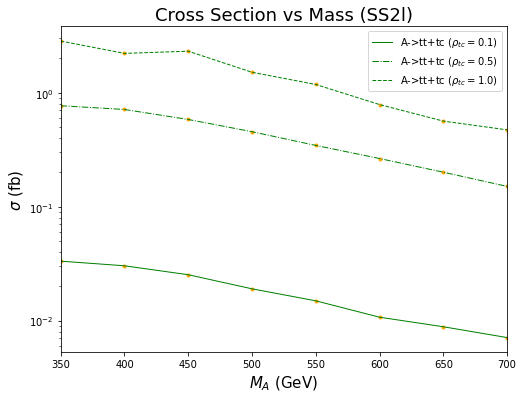

In [60]:
ma = np.linspace(350, 700, 8)
ss2l_a01 = [0.0003737, 0.0002779, 0.0001975, 0.0001419, 0.0001089, 8.117e-05, 6.092e-05, 4.579e-05]
ss2l_a05 = [0.009095, 0.006619, 0.004778, 0.003513, 0.002574, 0.001927, 0.001457, 0.001123]
ss2l_a10 = [0.03511, 0.02463, 0.01769, 0.01283, 0.009539, 0.007162, 0.005423, 0.004183]
ss2l_a01f = [ss2l_a01[i] * 1000 * f_01[i] for i in range(8)]
ss2l_a05f = [ss2l_a05[i] * 1000 * f_05[i] for i in range(8)]
ss2l_a10f = [ss2l_a10[i] * 1000 * f_10[i] for i in range(8)]
plt.figure(figsize=(8, 6))
plt.scatter(ma, ss2l_a01f, marker='.', c='orange')
plt.scatter(ma, ss2l_a05f, marker='.', c='orange')
plt.scatter(ma, ss2l_a10f, marker='.', c='orange')
plt.xlim(350, 700)
plt.yscale('log')
plt.plot(ma, ss2l_a01f, 'g-', label=r'A->tt+tc ($\rho_{tc}=0.1$)', linewidth=1)
plt.plot(ma, ss2l_a05f, 'g-.', label=r'A->tt+tc ($\rho_{tc}=0.5$)', linewidth=1)
plt.plot(ma, ss2l_a10f, 'g--', label=r'A->tt+tc ($\rho_{tc}=1.0$)', linewidth=1)

plt.title('Cross Section vs Mass (SS2l)', fontsize=18)
plt.xlabel(r'$M_{A}$ (GeV)', fontsize=15)
plt.ylabel(r'$\sigma$ (fb)', fontsize=15)
plt.legend(loc='upper right')
plt.show()

In [46]:
y1 = '../root/MG5_aMC_v2_7_3/test/Events/run_02/tag_1_delphes_events.root'
y2 = uproot.open(y1)
y3 = function(y2)

In [47]:
y3 = function(y2)

100%|██████████| 975/975 [00:00<00:00, 2018.52it/s]


In [48]:
y3[-1]/y3[0]

0.0876

In [63]:
m_10 = [m17, m18, m19, m20, m21, m22, m23, m24]
name = [r'Input Event Size',
        'SS2l Signature',
        r'leading jets > 30 GeV & subleading jets > 20 GeV & $|η^{l}|< 2.5$',
        r'leading leptons > 25 GeV & subleading leptons > 20 GeV & $|η^{b}| < 2.5$',
        r'$E_{T}^{miss}$',
        r'Δ$R_{bb}$ > 0.4',
        r'Δ$R_{bl}$ > 0.4',
        r'Δ$R_{ll}$ > 0.4',
        r'$H_{T}$ (2 leading leptons & 3 leading jets) > 300 GeV']
fd = pd.DataFrame({r'$M_{A}=350 GeV$': y3r'Selection Cut (SS2l)$\rho_{tc}=1.0$': name,
                   })
fd

,Selection Cut (SS2l)$\rho_{tc}=1.0$,$M_{A}=350 GeV$
0,Input Event Size,10000
1,SS2l Signature,1474
2,leading jets > 30 GeV & subleading jets > 20 G...,1169
3,leading leptons > 25 GeV & subleading leptons ...,1145
4,$E_{T}^{miss}$,994
5,Δ$R_{bb}$ > 0.4,994
6,Δ$R_{bl}$ > 0.4,994
7,Δ$R_{ll}$ > 0.4,975
8,$H_{T}$ (2 leading leptons & 3 leading jets) >...,876
